<center>**Assignment 
<br>
Gagandeep Singh
<br>
19/02/2019**</center>

 *Since the type of the data is complex first we need to do some pre-processing to extract the data suitable for our model.
Below I define a function which will extract Y's from json file and X to numpy arrays.*

In [1]:
import json
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def create_ds(path):
    os.chdir(path)
    Xtemp = np.zeros((4400,128), dtype = float)
    Ytemp = np.zeros((4400, 50), dtype = float)
    files = glob.glob('*.txt')
    for c,f in enumerate(files):
        Xtemp[c,:] = np.loadtxt(f)
        ofname = f.split('_')[0] + '_output.json'
        out = open(ofname,'r')
        json_decode = json.load(out)
        for j,key in enumerate(sorted(json_decode.keys())):
            Ytemp[c,j] = json_decode[key]      
    return Xtemp,Ytemp 


Let's extract the dataset

In [2]:
X,Y = create_ds(r'C:\Users\Matharu\Desktop\assignment\assignment_dataset')
Y[0,0]

0.2550382332385748

Let's explore how the individual Y values look like. As we can see below the different Y values in the whole dataset are spread from range 0-0.8 mostly.

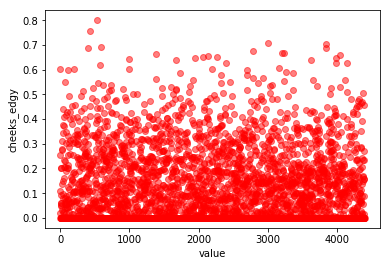

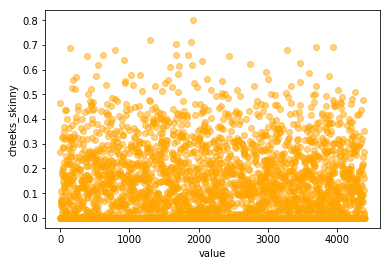

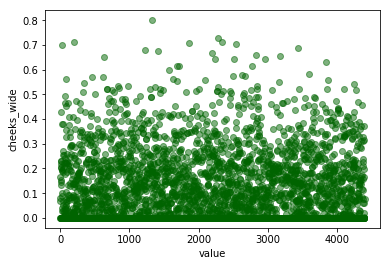

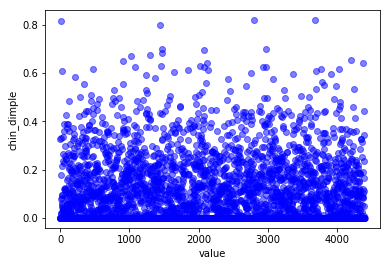

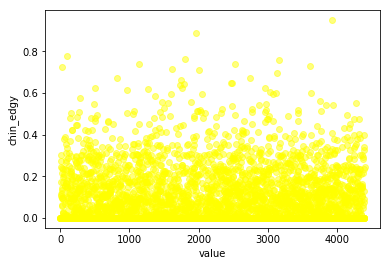

In [3]:
names = ['cheeks_edgy','cheeks_skinny','cheeks_wide','chin_dimple','chin_edgy']
colors = ['red','orange','darkgreen','blue','yellow']
for i in range(5):
    plt.plot(Y[:,i], 'o', alpha=0.5,color=colors[i])
    plt.xlabel('value')
    plt.ylabel(names[i])
    plt.show()

1. Split the data into train/valdation set:

In [4]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.8)

C:\Users\Matharu\Desktop\gmatharu\Softs\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


2. 3. Creating model and training it. Here I used the **sklearn** library and the model I selected here is an ensemble of tree's called **RandomForestRegressor**, because this model reduces overfitting and generalize well for new examples. 

In [5]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(100).fit(Xtrain, Ytrain)

Let's test this model on test data

In [15]:
Ypred = clf.predict(Xtest)
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(Ypred[:,0], Ytest[:,0]))
print("RMSE is: ",rms)

RMSE is:  0.13379101830393386


Let's visualize and compare some predicted outcome with test example:

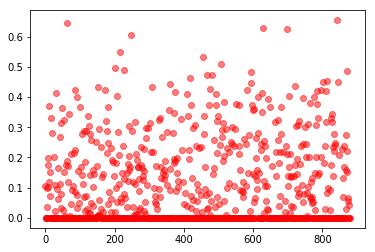

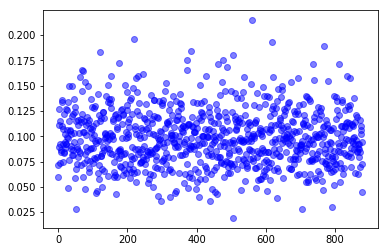

In [7]:
plt.plot(Ytest[:,0], 'o', alpha=0.5,color='red')
plt.show()
plt.plot(Ypred[:,0], 'o', alpha=0.5,color='blue')
plt.show()

As we can see from above the rms is very small, so overall this model does a good job of predicting the Y values.

I also looked through the dependence between the different output values as is show below in graph and by the pearson correlation coefficient. As we can see when one of the Y increases other does so or decrease, although its not so clear in some examples but we can see the correlation coefficient is high enough. 

The idea here is to use one of the Y's as features to predict another as there is clear dependency between Y's. I trained a model using different Y's as features.

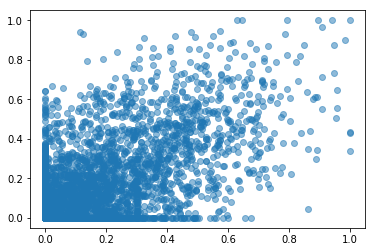

0.632811115044303


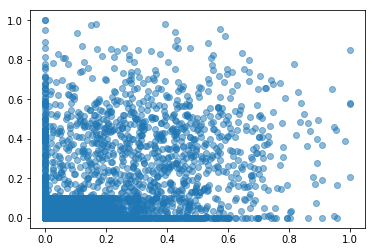

0.40997786417952625


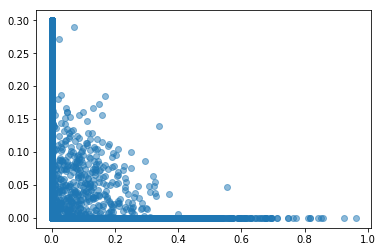

-0.4330295349676183


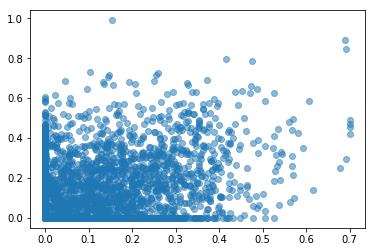

0.632811115044303


In [8]:
plt.plot(Y[:,29], Y[:,27], 'o', alpha=0.5)
plt.show()
print(np.corrcoef(Y[:,29], Y[:,27])[0,1])
plt.plot(Y[:,29], Y[:,31], 'o', alpha=0.5)
plt.show()
print(np.corrcoef(Y[:,29], Y[:,31])[0,1])
plt.plot(Y[:,42], Y[:,41], 'o', alpha=0.5)
plt.show()
print(np.corrcoef(Y[:,42], Y[:,41])[0,1])
plt.plot(Y[:,45],Y[:,17], 'o', alpha=0.5)
plt.show()
print(np.corrcoef(Y[:,29], Y[:,27])[0,1])

Let's modifiy the existing RandomForestRegressor to include our above logic and train the new model and test its accuracy:

In [9]:
class MultiOutputRFdependentYs(object):
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        
    def fit(self, X, Y):
        X, Y = map(np.atleast_2d, (X, Y))
        assert X.shape[0] == Y.shape[0]
        Ny = Y.shape[1]
        
        self.clfs = []
        for i in range(Ny):
            clf = RandomForestRegressor(*self.args, **self.kwargs)
            Xi = np.hstack([X, Y[:, :i]])
            yi = Y[:, i]
            self.clfs.append(clf.fit(Xi, yi))
            
        return self
        
    def predict(self, X):
        Y = np.empty([X.shape[0], len(self.clfs)])
        for i, clf in enumerate(self.clfs):
            Y[:, i] = clf.predict(np.hstack([X, Y[:, :i]]))
        return Y

In [10]:
clf1 = MultiOutputRFdependentYs(100).fit(Xtrain, Ytrain)
Ypred1 = clf1.predict(Xtest)

Let's see the rms of this model and visualize and compare some predicted outcome with test example. As we can see this model definitely shows some improvement compared to previous model as its rms is lower.

RMSE is:  0.13341180116542356


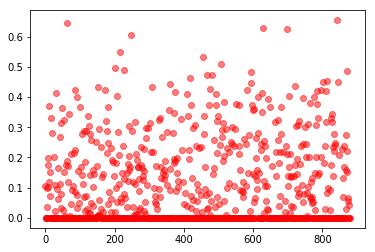

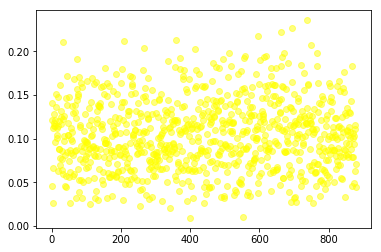

In [16]:
rms = sqrt(mean_squared_error(Ypred1[:,0], Ytest[:,0]))
print("RMSE is: ",rms)
plt.plot(Ytest[:,0], 'o', alpha=0.5,color='red')
plt.show()
plt.plot(Ypred1[:,0], 'o', alpha=0.5,color='yellow')
plt.show()

4. **Encoding vectors** are the 128D vectors which reprents the best features to encode a face. They have been derived from another deep learning model which has been trained on huge number of images by expert in the computer vision field. The model was trained using "triplets" of images and is one the of best one to encode a face.

If there is just an image/photograph is given we must run this model to predict the best 128D encoding vector of the face in the image. You have already procided me the link of some libraries.

There might be bunch of pre-processing steps that might be necessary before we derive the 128D encoding vector, for example: 
1. Dimensionality reduction
2. Warping to center the image

I also briefly looked through the paper on Encoding Vectors: https://www.cv-foundation.org/openaccess/content_cvpr_2015/app/1A_089.pdf

If we do not wish to use these encodings then we might create our own neural network called "autoencoder" which can learn to represent the faces in a compressed form. However that requires alot of data to be trained. 

**NOTE: I could have used more complex models like NN's and deep learning for this problem but that requires more data and a better machine**